In [1]:
import pandas as pd
import numpy as np
import googlemaps
import folium
import seaborn as sns; sns.set()
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans
from sklearn import preprocessing
%matplotlib inline

In [66]:
# hidden_cell
gmaps = googlemaps.Client(key='AIzaxxxxxxxxxxxxxxxxxxxxxxPTo')

### <a id="data_ac">Data Acquisition</a>

<img src="pics/IDA_logo.svg" alt="IDA" style="width:350px;"/>

Importing Companies Dataset. Downloaded from https://www.idaireland.com/doing-business-here/company-listing

In [192]:
dub_com = pd.read_csv('Features_csv/IDAcompanyweb.csv')

In [193]:
dub_com.columns

Index(['Company', 'Phone', 'Fax', 'Web', 'Sector(s)', 'Product', 'Nationality',
       'Address', 'Additional1', 'Additional2'],
      dtype='object')

Merging columns 'Address', 'Additional1', 'Additional2' into 'Address_fixed'

In [194]:
comma = ', '
# replacing Nan values for ', '
dub_com['Additional1'].replace(to_replace = np.nan, value = '', inplace=True)
dub_com['Additional2'].replace(to_replace = np.nan, value = '', inplace=True)
# merging columns
dub_com["Address_fixed"] = dub_com["Address"].astype(str) + comma +dub_com["Additional1"].astype(str) + comma + dub_com["Additional2"].astype(str)
# removing old columns
dub_com.drop(columns=['Address', 'Additional1', 'Additional2'], inplace=True)
print ('Dataset has {} companies'.format (dub_com.shape[0]))

Dataset has 1070 companies


Filtering Addresses with dublin

In [195]:
dub_com_city = dub_com[dub_com['Address_fixed'].astype(str).str.contains('Dublin')].copy()
print ('Dataset has {} companies'.format (dub_com_city.shape[0]))

Dataset has 528 companies


Renaming Address column and removing unnecessary columns

In [196]:
dub_com_city['Address']= dub_com_city['Address_fixed']
dub_com_city.drop(columns=['Phone', 'Fax', 'Web', 'Address_fixed'], inplace=True)
dub_com_city.reset_index(drop=True, inplace=True)
dub_com_city.head(2)

,Company,Sector(s),Product,Nationality,Address
0,Symantec Limited,ICT- ICT - Software,Package Software for PC and Mac and technical ...,United States of America,Ballycoolin Industrial Park Blanchardstown Du...
1,Ig International Management Limited,Financial Services,Asset Management - owned by Power Financial Gr...,Canada,Brooklawn House Shelbourne Road Ballsbridge Du...


Testing API first with 5 rows..

In [197]:
# Generates a new dataframe with x random rows / same that using df.sample(5)
def random_rows(df, nrows):
    import random
    df_random = pd.DataFrame()
    rnd_lst = [random.randint(0, len(df)) for iter in range(nrows)]
    for num in rnd_lst:
        df_random = df_random.append(df.iloc[num, :])
    df_random = df_random.reset_index(drop=True)
    return df_random

In [153]:
dub_com_city_test = pd.DataFrame()
dub_com_city_test = random_rows(dub_com_city, 5)

Function to get the Coordinates for each company using Google API

In [159]:
def getCoordinates(names, addresses):
    
    Coordinates_list=[]
    for name, address in zip(names, addresses):
        space = '     '
        print(name +'{}'.format(10*space), end="\r", flush=True)
        query = gmaps.geocode(address)

        Coordinates_list.append([(
            name, 
            v['formatted_address'],
            v['geometry']['location']['lat'], 
            v['geometry']['location']['lng']) for v in query])

    Company_Coordinates = pd.DataFrame([item for Coordinate_list in Coordinates_list for item in Coordinate_list])
    Company_Coordinates.columns = ['Company',
                  'Address',
                  'Latitude', 
                  'Longitude']

    return(Company_Coordinates)

In [163]:
company_gmap_coordinates = getCoordinates(names = dub_com_city['Company'],
                                   addresses = dub_com_city['Address']
                                  )

In [184]:
company_gmap_coordinates.head(2)

,Company,Address,Latitude,Longitude
0,Symantec Limited,"Ballycoolen, Dublin 15, Ireland",53.412959,-6.373212
1,Ig International Management Limited,"Brooklawn House, Shelbourne Rd, Ballsbridge, D...",53.332099,-6.230495


Removing companies outside the project scope boundaries

In [187]:
#these are the coordenates boundary
xmin, xmax, ymin, ymax = -6.295547, -6.227464, 53.322556, 53.356207
com_list = company_gmap_coordinates.copy()
company_geo_list = com_list.drop(com_list[(com_list.Latitude < ymin) 
                                          | (com_list.Latitude > ymax)
                                          | (com_list.Longitude < xmin)
                                          | (com_list.Longitude > xmax)].index)

company_geo_list.reset_index(drop=True, inplace=True)
print ('Dataframe has been reduced from {} to {} companies'.format 
       (str(company_gmap_coordinates.shape[0]), 
        str(company_geo_list.shape[0])))

Dataframe has been reduced from 592 to 311 companies


Adding Classification column / Renaming 'Company' to 'Name' in order to use with other datasets

In [188]:
company_geo_list['Classification'] = 'Company'
company_geo_list.rename(columns={'Company':'Name'}, inplace=True)

In [198]:
company_geo_list.drop(columns=['Address'], inplace=True)

In [199]:
company_geo_list.head()

,Name,Latitude,Longitude,Classification
0,Ig International Management Limited,53.332099,-6.230495,Company
1,Belfius Ireland,53.349242,-6.246286,Company
2,Northern Trust Management Services (Ireland) L...,53.345858,-6.250761,Company
3,Gam Fund Management Limited,53.345858,-6.250761,Company
4,Airbus Financial Services,53.349628,-6.246303,Company


Saving Dataframe as CSV file to use it in the project

In [200]:
# company_geo_list.to_csv('Features_csv/company_geo_list.csv', index=False)

Map with companies within the project scope 

In [2]:
# company_geo_list = pd.read_csv('Features_csv/company_geo_list.csv')

In [3]:
dub_latitude = '53.341785'
dub_longitude = '-6.265288'
# create map of Dublin using latitude and longitude values
map_dublin = folium.Map(location=[dub_latitude, dub_longitude], tiles='CartoDB dark_matter', zoom_start=14)

# add markers to map
for lat, lng, label in zip(company_geo_list['Latitude'], company_geo_list['Longitude'], company_geo_list['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)

map_dublin

In [10]:
company_geo_list.shape

(311, 4)

In [11]:
company_geo_list.drop_duplicates(subset='Name', inplace=True)
company_geo_list.reset_index(drop=True, inplace=True)

In [12]:
company_geo_list.shape

(287, 4)

We can see some outliers. 3 on the top and 3 on the button. Let's filtering them in order to increase clustering accuracy

In [13]:
company_geo_list.sort_values(by=['Latitude'], ascending=False).head(3)

,Name,Latitude,Longitude,Classification
186,Ava Capital Markets Limited,53.354926,-6.246700,Company
173,Colt Technology Services Limited,53.353822,-6.228840,Company
200,HCL Technologies,53.352993,-6.259181,Company


These 3 are on the top

In [14]:
company_geo_list.sort_values(by=['Latitude']).head(3)

,Name,Latitude,Longitude,Classification
178,Data Clarity Emea,53.323510,-6.258931,Company
134,Procuro Euro Limited,53.323869,-6.261282,Company
253,Amanie Advisors (Ireland) Ltd,53.324329,-6.241397,Company


These 3 are on the bottom.Removing top & bottom ones. Popup label in the map to double-check them

In [15]:
company_geo_list.drop([company_geo_list.index[186], 
                       company_geo_list.index[173], 
                       company_geo_list.index[200], 
                       company_geo_list.index[178], 
                       company_geo_list.index[134], 
                       company_geo_list.index[253]], inplace=True)

In [16]:
company_geo_list.reset_index(drop=True, inplace=True) # reseting index due to 6 rows have been removed

In [18]:
company_geo_list.shape

(281, 4)

Clustering data (coordinates) using K-means  

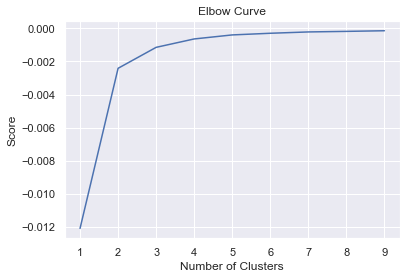

In [19]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = company_geo_list[['Latitude']]
X_axis = company_geo_list[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [20]:
kmeans = KMeans(n_clusters = 5, init ='k-means++', n_init=30, max_iter=700)
kmeans.fit(company_geo_list[company_geo_list.columns[1:3]]) # Compute k-means clustering.
company_geo_list['Cluster label'] = kmeans.fit_predict(company_geo_list[company_geo_list.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(company_geo_list[company_geo_list.columns[1:3]]) # Labels of each point
company_geo_list.head()

,Name,Latitude,Longitude,Classification,Cluster label
0,Ig International Management Limited,53.332099,-6.230495,Company,4
1,Belfius Ireland,53.349242,-6.246286,Company,2
2,Northern Trust Management Services (Ireland) L...,53.345858,-6.250761,Company,2
3,Gam Fund Management Limited,53.345858,-6.250761,Company,2
4,Airbus Financial Services,53.349628,-6.246303,Company,2


In [569]:
#company_geo_list.to_csv('Features_csv/company_geo_list_clusters.csv', index=False)

In [21]:
centers

array([[53.33519377, -6.25538215],
       [53.34351417, -6.23807577],
       [53.34813304, -6.24982413],
       [53.34311818, -6.27234464],
       [53.33109075, -6.23133278]])

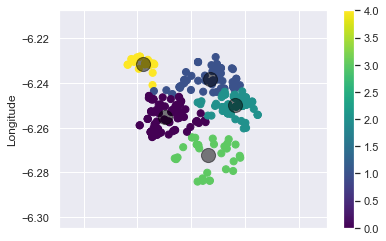

In [22]:
company_geo_list.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [23]:
centers

array([[53.33519377, -6.25538215],
       [53.34351417, -6.23807577],
       [53.34813304, -6.24982413],
       [53.34311818, -6.27234464],
       [53.33109075, -6.23133278]])

Albeit K-means optimal number of clusters was 3, 5 clusters have been created due to the model will work better knowing the city areas.<br>Let's visualize using folium

In [4]:
clusters_colors = {'0':'yellow', '1':'blue', '2':'red', '3':'green', '4':'purple'}
dub_latitude = '53.341785'
dub_longitude = '-6.265288'
# create map of Dublin using latitude and longitude values
map_dublin = folium.Map(location=[dub_latitude, dub_longitude], 
                        tiles='CartoDB dark_matter', zoom_start=14)

# add markers to map
for lat, lng, label, cluster in zip(company_geo_list['Latitude'], 
                                  company_geo_list['Longitude'], 
                                  company_geo_list['Name'], 
                                  company_geo_list['Cluster label'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=clusters_colors[cluster],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)
    
for center in centers:    
    folium.CircleMarker(
            center,
            radius=10,
            color='white',
            fill=True,
            fill_color='#888888',
            fill_opacity=0.4,
            parse_html=False).add_to(map_dublin)

map_dublin

KeyError: 'Cluster label'

Let's make some tunning passing 3 companies to a different cluster (from blue to yellow)
- Blackstone Group LP
- Axway
- Gerson Lehrman Group

In [25]:
print(company_geo_list[company_geo_list['Name'].astype(str).str.contains('Blackstone Group LP')]['Name'])
print(company_geo_list[company_geo_list['Name'].astype(str).str.contains('Axway')]['Name'])
print(company_geo_list[company_geo_list['Name'].astype(str).str.contains('Gerson Lehrman Group')]['Name'])

194    Blackstone Group LP
Name: Name, dtype: object
243    Axway
Name: Name, dtype: object
119    Gerson Lehrman Group
Name: Name, dtype: object


In [28]:
company_geo_list.loc[194,'Cluster label']=0
company_geo_list.loc[243,'Cluster label']=0
company_geo_list.loc[119,'Cluster label']=0

In [29]:
clusters_colors = {'0':'yellow', '1':'blue', '2':'red', '3':'green', '4':'purple'}
dub_latitude = '53.341785'
dub_longitude = '-6.265288'
# create map of Dublin using latitude and longitude values
map_dublin = folium.Map(location=[dub_latitude, dub_longitude], 
                        tiles='CartoDB dark_matter', zoom_start=14)

# add markers to map
for lat, lng, label, cluster in zip(company_geo_list['Latitude'], 
                                  company_geo_list['Longitude'], 
                                  company_geo_list['Name'], 
                                  company_geo_list['Cluster label'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=clusters_colors[cluster],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)
    
for center in centers:
    label = folium.Popup(str(center), parse_html=True)
    folium.CircleMarker(
            center,
            radius=10,
            popup=label,
            color='white',
            fill=True,
            fill_color='#888888',
            fill_opacity=0.4,
            parse_html=False).add_to(map_dublin)

map_dublin

Now we create a dataframe with the centroids and add a column with the index values that correspond to the clusters label

In [30]:
centers

array([[53.33519377, -6.25538215],
       [53.34351417, -6.23807577],
       [53.34813304, -6.24982413],
       [53.34311818, -6.27234464],
       [53.33109075, -6.23133278]])

In [31]:
centers_df = pd.DataFrame(data=centers, columns=['Latitude', 'Longitude'])
centers_df['Cluster label'] = centers_df.index

In [32]:
centers_df

,Latitude,Longitude,Cluster label
0,53.335194,-6.255382,0
1,53.343514,-6.238076,1
2,53.348133,-6.249824,2
3,53.343118,-6.272345,3
4,53.331091,-6.231333,4


In [162]:
# company_geo_list.to_csv('Companies_clusters.csv', index=False)
# centers_df.to_csv('Companies_clusters_centroids_df.csv', index=False)

In [5]:
company_geo_list = pd.read_csv('Features_csv/Companies_clusters.csv')
centers_df = pd.read_csv('Features_csv/Companies_clusters_centroids_df.csv')

In [6]:
clusters_colors = {'0':'yellow', '1':'blue', '2':'red', '3':'green', '4':'purple'}
dub_latitude = '53.341785'
dub_longitude = '-6.265288'
# create map of Dublin using latitude and longitude values
map_dublin = folium.Map(location=[dub_latitude, dub_longitude], 
                        tiles='CartoDB dark_matter', zoom_start=14)

# add markers to map
for lat, lng, label, cluster in zip(company_geo_list['Latitude'], 
                                  company_geo_list['Longitude'], 
                                  company_geo_list['Name'], 
                                  company_geo_list['Cluster label'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=clusters_colors[cluster],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)
    
for lat, lng, label in zip(centers_df['Latitude'], 
                                  centers_df['Longitude'], 
                                  centers_df['Cluster label'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
            [lat, lng],
            radius=10,
            popup=label,
            color='white',
            fill=True,
            fill_color='#888888',
            fill_opacity=0.4,
            parse_html=False).add_to(map_dublin)

map_dublin

#### <center><font color=yellow>__Cluster 0__</font>, <font color=blue>__Cluster 1__</font>, <font color=red>__Cluster 2__</font>, <font color=green>__Cluster 3__</font>, <font color=purple>__Cluster 4__</font></center>

### <center><a href="./f.Districts_Geopandas.ipynb#data_ac">NEXT CHAPTER</a></center>

#### <center> <a href="./../0.Table_of_Contents_Code.ipynb">Table of Contents</a><br></center>